In [1]:
import pymongo
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from kubernetes import client,config,watch

In [2]:
mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongoclient['resource-v2']

In [3]:
collist = db.list_collection_names()
collist

['requests', 'usage']

In [4]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [5]:
record = {}
for col in collist:
    record[col] = pd.DataFrame(list(db[col].find()))
    # convert timestamp to time
    record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
    record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
    record[col]['cpu'] = record[col]['cpu'].fillna(0)
    record[col]['memory'] = record[col]['memory'].apply(lambda x: convert_mem(x))

In [6]:
request = record['requests']
usage = record['usage']
request = request[request['pod_name'] != 'ycsb']
usage = usage[usage['pod_name'] != 'ycsb']
usage.head()

,_id,time,cpu,memory,pod_name
0,60bf294e59a9e66b23132122,2021-06-08 08:24:46,2.0,4.0,redis-master-0
1,60bf294e59a9e66b23132123,2021-06-08 08:24:46,0.0,3.0,redis-master-1
3,60bf294f59a9e66b23132128,2021-06-08 08:24:47,2.0,4.0,redis-master-0
4,60bf294f59a9e66b23132129,2021-06-08 08:24:47,0.0,3.0,redis-master-1
6,60bf295059a9e66b2313212e,2021-06-08 08:24:48,2.0,4.0,redis-master-0


In [7]:
pod_usage = {}
for i in usage['pod_name'].unique():
    pod_usage[i] = usage[usage['pod_name'] == i]
    
pod_request = {}
for i in request['pod_name'].unique():
    pod_request[i] = request[request['pod_name'] == i]
print('len(pod_usage) =',len(pod_usage))
print('len(pod_request) =',len(pod_request))

len(pod_usage) = 2
len(pod_request) = 2


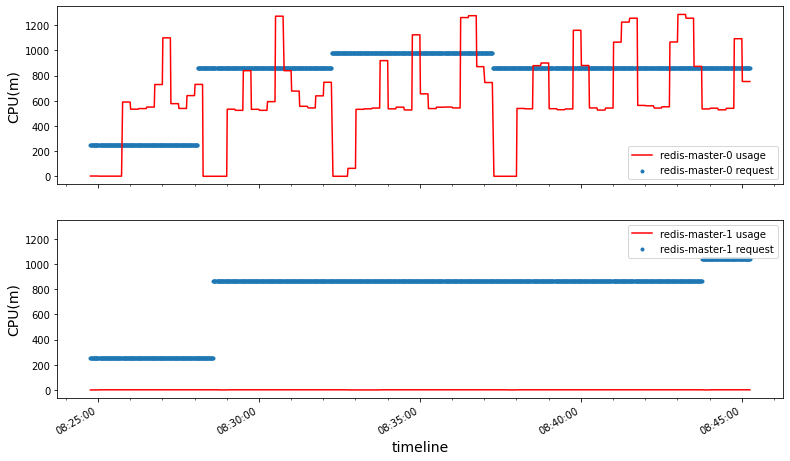

In [8]:
fig, ax = plt.subplots(len(pod_request),1,figsize=(13,8),sharex=True,sharey=True)
for index,pod in enumerate(pod_request):
    ax[index].scatter(pod_request[pod].time, pod_request[pod].cpu,marker='.',label=pod +' request')
    ax[index].plot(pod_usage[pod].time, pod_usage[pod].cpu,label=pod +' usage',color='r')
    ax[index].legend()
    ax[index].set_ylabel('CPU(m)', fontsize=14)
    ax[index].set_xlabel('timeline', fontsize=14)
    ax[index].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax[index].xaxis.set_minor_locator(mdates.MinuteLocator())
fig.autofmt_xdate() #rotate labels
plt.show()

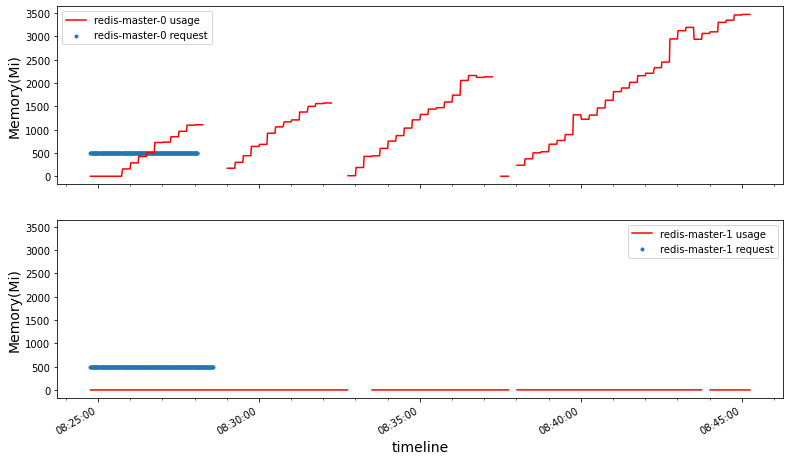

In [9]:
fig, ax = plt.subplots(len(pod_request),1,figsize=(13,8),sharex=True,sharey=True)
for index,pod in enumerate(pod_request):
    ax[index].scatter(pod_request[pod].time, pod_request[pod].memory,marker='.',label=pod +' request')
    ax[index].plot(pod_usage[pod].time, pod_usage[pod].memory,label=pod +' usage',color='r')
    ax[index].legend()
    ax[index].set_ylabel('Memory(Mi)', fontsize=14)
    ax[index].set_xlabel('timeline', fontsize=14)
    ax[index].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax[index].xaxis.set_minor_locator(mdates.MinuteLocator())
fig.autofmt_xdate() #rotate labels
plt.show()

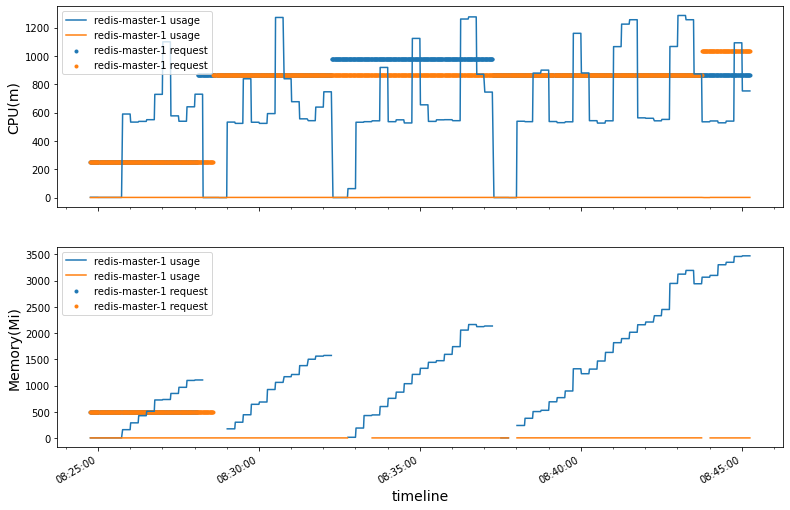

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,9))
for i in pod_request.keys():
    ax1.scatter(pod_request[i].time, pod_request[i].cpu,marker='.',label=pod+' request')
    ax1.plot(pod_usage[i].time, pod_usage[i].cpu, label=pod + ' usage')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.xaxis.set_minor_locator(mdates.MinuteLocator())
ax1.set_ylabel('CPU(m)', fontsize=14)
ax1.set_xlabel('timeline', fontsize=14)
ax1.legend()

for i in pod_request.keys():
    ax2.scatter(pod_request[i].time, pod_request[i].memory,marker='.',label=pod+' request')
    ax2.plot(pod_usage[i].time, pod_usage[i].memory, label=pod + ' usage')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.xaxis.set_minor_locator(mdates.MinuteLocator())
ax2.set_ylabel('Memory(Mi)', fontsize=14)
ax2.set_xlabel('timeline', fontsize=14)
ax2.legend()

fig.autofmt_xdate() #rotate labels
plt.show()